In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skinematics as skin

In [2]:
def calculate_patch_radius(patch_area_sq_degrees):
    return np.arccos(1-patch_area_sq_degrees*np.pi/(2*180*180))

def calculate_patch_area(patch_radius): 
    # patch is basically a spherical cap centered around the North Pole on a sphere of unit radius
    r = 1
    return 2*np.pi*r*r*(1-np.cos(patch_radius)) # from Wikipedia

def calculate_theta_scale(theta_scale_arcmins):
    return theta_scale_arcmins/60*np.pi/180

sq_degrees = 7000
theta_scale_arcmins = 500

patch_radius = calculate_patch_radius(sq_degrees)
#patch_radius = np.pi
patch_area = calculate_patch_area(patch_radius)
theta_scale = calculate_theta_scale(theta_scale_arcmins)
#theta_scale = 0.008 

In [3]:
def spherical_to_cartesian(P_sph, sph_units):
    # r , theta, phi 
    r = P_sph[0]
    theta = 0
    phi = 0
    if (sph_units == 'deg'):
        theta = np.deg2rad(P_sph[1])
        phi = np.deg2rad(P_sph[2])
    elif (sph_units == 'rad'):
        theta = P_sph[1]
        phi = P_sph[2]  
    else:
        raise Exception('units should be either \'deg\' or \'rad\'')
   
    return np.array([r*np.sin(theta)*np.cos(phi),r*np.sin(theta)*np.sin(phi),r*np.cos(theta)])

def cartesian_to_spherical(P_cart, sph_units):
    # x, y, z ---> r, theta, phi 
    x = P_cart[0]
    y = P_cart[1]
    z = P_cart[2]
    
    r = np.sqrt(x*x+y*y+z*z)
    
    theta = np.arctan2(np.sqrt(x*x+y*y), z)
        
    phi = np.arctan2(y,x)
    if phi < 0:
        phi = 2*np.pi + phi
    
    if (sph_units == 'deg'):
        return np.array([r, theta*180/np.pi, phi*180/np.pi])
    elif (sph_units == 'rad'):
        return np.array([r, theta, phi])
    else:
        raise Exception('units should be either \'deg\' or \'rad\'')

def rotate_vector_to_NP_matrices(P_sph, P_sph_units):
    # retrieve matrices to rotate a vector to the North Pole
    theta = 0
    phi = 0
    if (P_sph_units == 'deg'):
        theta = P_sph[1]
        phi = P_sph[2]         
    elif (P_sph_units == 'rad'):
        theta = np.rad2deg(P_sph[1])
        phi = np.rad2deg(P_sph[2])
    else:
        raise Exception('units should be either \'deg\' or \'rad\'')
        
    # First rotate about z axis (counter azimuthally) so as to make the point lie in the xz plane i.e. y = 0
    Rot_z = skin.rotmat.R(axis='z', angle=-phi) # skin.rotmar.R only accepts angle in degrees!   
    
    # Then rotate about y axis (counter polar-wise) to make the point lie at the NP i.e. x = 0, y = 0
    Rot_y = skin.rotmat.R(axis='y', angle=-theta) # skin.rotmar.R only accepts angle in degrees!
       
    return np.array([Rot_z, Rot_y]) # 1st rotation matrix and then 2nd rotation matrix

def draw_pt_within_patch(patch_radius, patch_area):

    theta = np.random.uniform(0, patch_radius, 1)[0]
    phi = np.random.uniform(0, 2*np.pi, 1)[0]
    
    # random point in the patch using the ideology behind picking a point uniformly on a unit sphere from http://corysimon.github.io/articles/uniformdistn-on-sphere/
    #theta = np.arccos(1-patch_area*np.random.uniform(0, 1, 1)[0]/(2*np.pi)) # Anik transformation
    #theta = np.arccos(np.cos(patch_radius)+patch_area*np.random.uniform(0, 1, 1)[0]/(2*np.pi)) # Oliver transformation

    return [theta, phi]

def draw_pt_on_circle_within_patch(omega_1, theta_scale, patch_radius):
    R_1, R_2 = rotate_vector_to_NP_matrices([1, omega_1[0], omega_1[1]], 'rad')
    
    theta_2_prime = theta_scale # polar angle in the rotated frame
    
    omega_2_3d_sph = np.zeros(3)
    phi_2_prime = np.random.uniform(0, 2*np.pi, 1)[0]
    omega_2_prime_cart = spherical_to_cartesian([1, theta_2_prime, phi_2_prime], 'rad') # set radius of sphere to 1
    omega_2_3d_sph = cartesian_to_spherical(np.matmul(R_1.T, np.matmul(R_2.T, omega_2_prime_cart)), 'rad')

    if (omega_2_3d_sph[1] > patch_radius):
        return [float('nan'), omega_2_3d_sph[2]]
    else:
        return [omega_2_3d_sph[1], omega_2_3d_sph[2]]

In [4]:
radius_list_pt1 = []
theta_list_pt1 = []
phi_list_pt1 = []

x_pt1 = []
y_pt1 = []
z_pt1 = []

radius_list_pt2 = []
theta_list_pt2 = []
phi_list_pt2 = []

x_pt2 = []
y_pt2 = []
z_pt2 = []

radius_list_pt3 = []
theta_list_pt3 = []
phi_list_pt3 = []

x_pt3 = []
y_pt3 = []
z_pt3 = []

def reinitialize():
    radius_list_pt1.clear()
    theta_list_pt1.clear()
    phi_list_pt1.clear()

    x_pt1.clear()
    y_pt1.clear()
    z_pt1.clear()

    radius_list_pt2.clear()
    theta_list_pt2.clear()
    phi_list_pt2.clear()

    x_pt2.clear()
    y_pt2.clear()
    z_pt2.clear()

    radius_list_pt3.clear()
    theta_list_pt3.clear()
    phi_list_pt3.clear()

    x_pt3.clear()
    y_pt3.clear()
    z_pt3.clear()
    
def draw_points(theta_scale, patch_radius, patch_area, N=1):
    
    reinitialize()
    
    for i in range(N):
        theta_1, phi_1 = draw_pt_within_patch(patch_radius, patch_area)
        theta_2, phi_2 = draw_pt_within_patch(patch_radius, patch_area)
        theta_3, phi_3 = draw_pt_on_circle_within_patch([theta_1, phi_1], theta_scale, patch_radius)
        
        if (not np.isnan(theta_3)):
            r = 1
            radius_list_pt1.append(r)
            theta_list_pt1.append(theta_1)
            phi_list_pt1.append(phi_1)
            
            x_pt1.append(r*np.sin(theta_1)*np.cos(phi_1))
            y_pt1.append(r*np.sin(theta_1)*np.sin(phi_1))
            z_pt1.append(r*np.cos(theta_1))
            
            radius_list_pt2.append(1)
            theta_list_pt2.append(theta_2)
            phi_list_pt2.append(phi_2)
            
            x_pt2.append(r*np.sin(theta_2)*np.cos(phi_2))
            y_pt2.append(r*np.sin(theta_2)*np.sin(phi_2))
            z_pt2.append(r*np.cos(theta_2))
            
            radius_list_pt3.append(1)
            theta_list_pt3.append(theta_3)
            phi_list_pt3.append(phi_3)
            
            x_pt3.append(r*np.sin(theta_3)*np.cos(phi_3))
            y_pt3.append(r*np.sin(theta_3)*np.sin(phi_3))
            z_pt3.append(r*np.cos(theta_3))
          

<IPython.core.display.Javascript object>


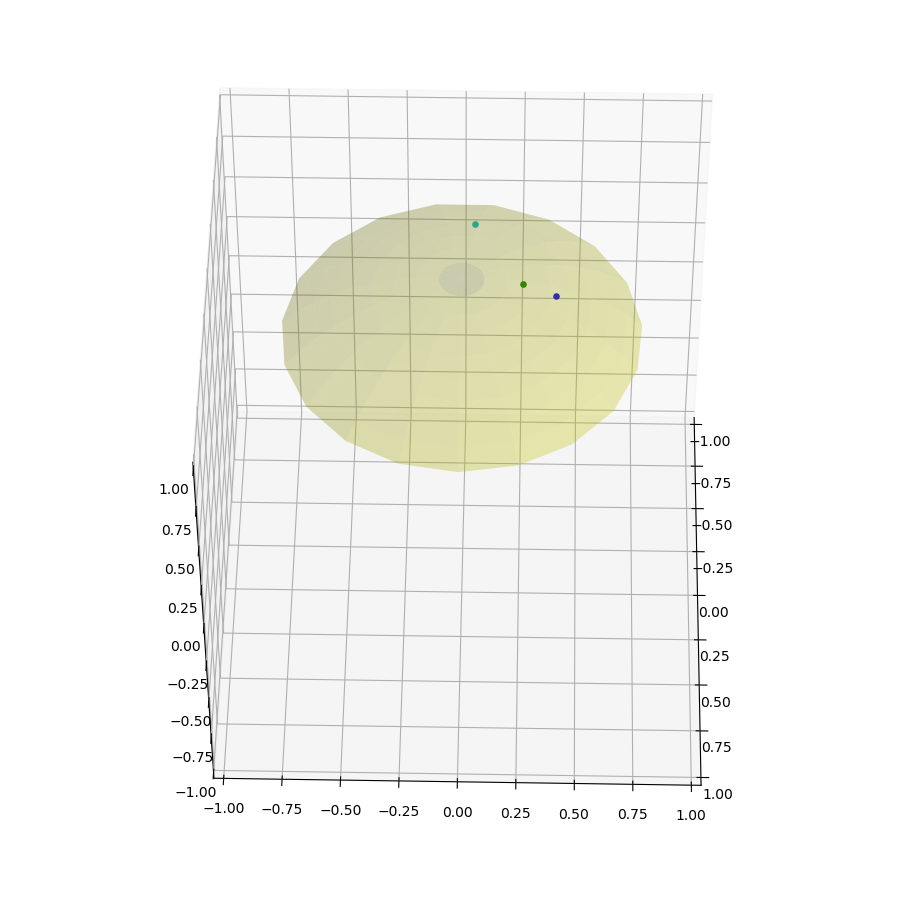

In [16]:
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib notebook

draw_points(theta_scale, patch_radius, patch_area, 1)

# Create a sphere
r = 1

theta, phi = np.mgrid[0.0:patch_radius:10j, 0.0:2.0*np.pi:20j]
x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

#Set colours and render
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface( x, y, z,  rstride=1, cstride=1, color='y', alpha=0.3, linewidth=0)

#ax.plot_wireframe(x, y, z, color="r", rcount=2, ccount = 6)

ax.scatter(x_pt1, y_pt1, z_pt1, color="g", s=14) # green
ax.scatter(x_pt2, y_pt2, z_pt2, color="c", s=14) # cyan
ax.scatter(x_pt3, y_pt3, z_pt3, color="b", s=14) # blue


ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

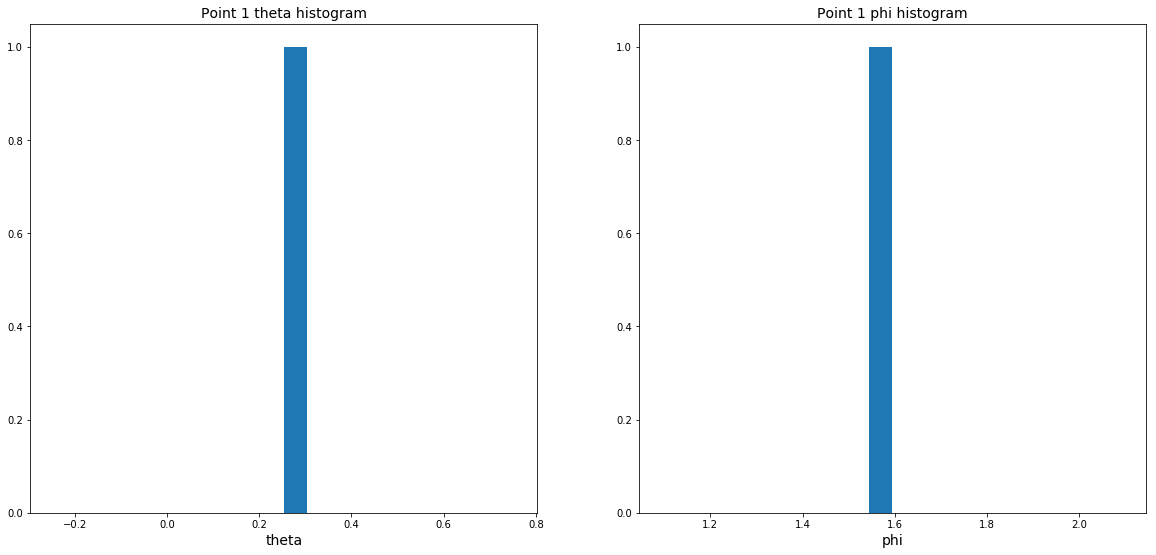

In [17]:
%matplotlib inline
fig1 = plt.figure(figsize=(20, 9))
sp1 = fig1.add_subplot(121)
sp1.hist(theta_list_pt1, bins = 20)
sp1.set_xlabel('theta', fontsize=14)
sp1.set_title('Point 1 theta histogram', fontsize=14);
sp2 = fig1.add_subplot(122)
sp2.hist(phi_list_pt1, bins = 20)
sp2.set_xlabel('phi', fontsize=14)
sp2.set_title('Point 1 phi histogram', fontsize=14);

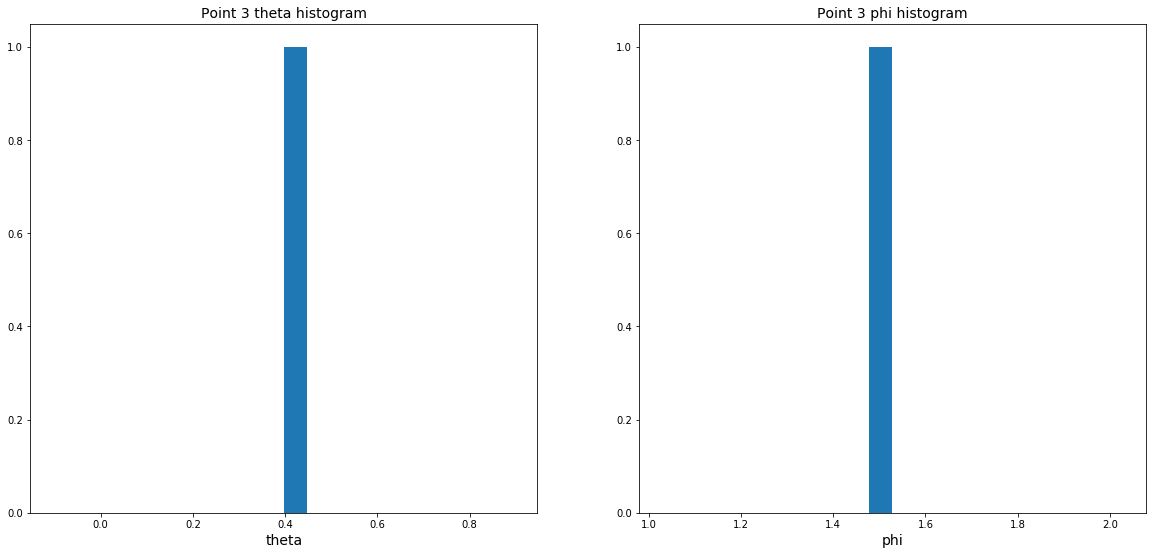

In [18]:
%matplotlib inline
fig3 = plt.figure(figsize=(20, 9))
sp1 = fig3.add_subplot(121)
sp1.hist(theta_list_pt3, bins = 20)
sp1.set_xlabel('theta', fontsize=14)
sp1.set_title('Point 3 theta histogram', fontsize=14);
sp2 = fig3.add_subplot(122)
sp2.hist(phi_list_pt3, bins = 20)
sp2.set_xlabel('phi', fontsize=14)
sp2.set_title('Point 3 phi histogram', fontsize=14);

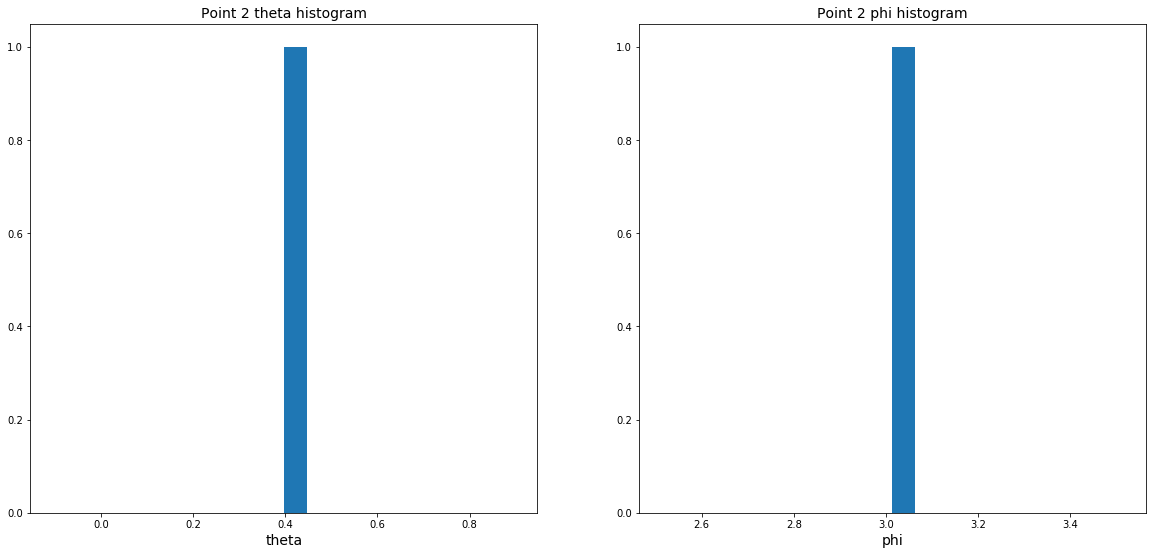

In [19]:
%matplotlib inline
fig2 = plt.figure(figsize=(20, 9))
sp1 = fig2.add_subplot(121)
sp1.hist(theta_list_pt2, bins = 20)
sp1.set_xlabel('theta', fontsize=14)
sp1.set_title('Point 2 theta histogram', fontsize=14);
sp2 = fig2.add_subplot(122)
sp2.hist(phi_list_pt2, bins = 20)
sp2.set_xlabel('phi', fontsize=14)
sp2.set_title('Point 2 phi histogram', fontsize=14);